# **Classification of Pneumonia Chest X-Ray Images using Transfer Learning**

## **Introduction**

In the current project, a data set of chest X-ray images (obtained from Kaggle) is used to predict pneumonia by classifying images to either normal or pneumonia category. The dataset contains total of 5,863 X-Ray images (JPEG), organized into 3 folders (train, test, val), in which each folder is divided into two category subfolders (Pneumonia/Normal).

These images were used for training CNN models using the approach of Transfer Learning. Specifically, pre-trained VGG-16 and VGG19 CNN models were used, following minor modification to fit the models to the specific binary classification problem at hand. Importantly, the preprocessing template presented in this notebook can be used for implementing additional state-of-the-art pre-trained CNN models available by tf.keras, including Xception, ResNet, ResNetV2, NASNet, and more.

In the second part of the project images of pneumonia patients were divided into two additional categories ("Bacteria"/"Virus") to predict the type of infection causing the disease.   


## **Table of contents:**

1. Loading and exploring the data
2. Visualizing images from the Normal and Pneumonia classes
3. Image data generation
4. Define functions for learning diagnostics and image preprocessing before prediction/evaluation
5. Transfer learning - using the VGG-16 CNN model
6. Transfer learning - using the VGG-19 CNN model
7. Prediction of bacterial vs. viral infections among the diagnosed pneumonia patient population




# 1. **Loading and exploring the data**

## 1.1. Importing the required libraries

In [0]:
# By defualt, Colabs satarted using Tensorflow 2 from the 27.3.20.
# Since the code was originaly writen using TF version 1 beckend, here I used the '%tensorflow_version 1.x' magic to downgrade TF version.
# For more information of TF versions, see: https://colab.research.google.com/notebooks/tensorflow_version.ipynb#scrollTo=8dSlimhOVxlQ

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
from glob import glob
import shutil
import sys

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from keras.layers import Flatten
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 1.2. Mounting / unmounting google drive in Colab

The project was conducted in Google Colaboratory (Colab), providing a free GPU resources, in integration with Google Drive for storing the image dataset and trained models. From this point of view, this notebook provide an example for an integrated workflow with Colab, Google Drive, and Kaggle.    

In [0]:
# For more information see: https://colab.research.google.com/drive/1v42TP4CrZlzp5y9_4LHJdCc5QB9RXk5Q

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Unmounting google drive from Colab
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


## 1.3. Download the dataset directly to Google Drive
For downloading Kaggle datasets via Kaggle API, follow the follwing steps: 


Step 1 — Get the API key from your account: 
www.kaggle.com ⇨ login ⇨ My Account ⇨ Create New API Token

Step 2 — Upload the kaggle.json file

Step 3 — Search for datasets

Step 4 — Download the required dataset + unzip

### 1.3.1. Upload the kaggle.json file and creating the necessary folder path



In [0]:
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"omrimatalon","key":"72206f779739e4f6a78db8b0bc2a8311"}'}

In [0]:
#The below will create the necessary folder path.
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json # set permission

kaggle.json


### 1.3.2. Search for datasets and competitions by name

For further information, see Kaggle API docs: https://www.kaggle.com/docs/api 

In [0]:
!kaggle datasets list -s chest-xray-pneumonia
!kaggle competitions list -s chest-xray-pneumonia

ref                                                              title                                               size  lastUpdated          downloadCount  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
paultimothymooney/chest-xray-pneumonia                           Chest X-Ray Images (Pneumonia)                       2GB  2018-03-24 19:41:59          46649  
khoongweihao/covid19-xray-dataset-train-test-sets                COVID-19 Xray Dataset (Train & Test Sets)           84MB  2020-03-19 01:49:56            352  
tawsifurrahman/covid19-radiography-database                      COVID-19 Radiography Database                        1GB  2020-03-28 23:36:00            570  
darshan1504/covid19-detection-xray-dataset                       COVID-19 Detection X-Ray Dataset                   186MB  2020-03-22 13:17:18            256  
praveengovi/coronahack-chest-xraydataset

### 1.3.3. Download and unzip the dataset files to a specified folder

In [0]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia -p /content/drive/My\ Drive/Chest_XRay_Images_Pneumonia_Classification --unzip

100% 2.29G/2.29G [00:31<00:00, 53.1MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.6MB/s]
y


### 1.3.4. Exploring the data set 

Checking the number and names of classes, and printing the number of images in the train and test sets 

In [0]:
train_data_dir = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train'  
validation_data_dir = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/val'  
test_data_dir = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test' 
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model')
print('\n - Names of classes: ', target_names, '\n - Number of classes: ', nb_classes)

print(' - Number of trained samples: ', nb_train_samples, '\n - Number of validation samples: ', nb_validation_samples,
      '\n - Number of test samples: ', nb_test_samples,
       '\n - Total Number of samples: ', total_nb_samples, '\n - Train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - Validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - Test ratio:', round(nb_test_samples/total_nb_samples*100, 2))

Training a CNN Multi-Classifier Model

 - Names of classes:  ['PNEUMONIA', 'NORMAL'] 
 - Number of classes:  2
 - Number of trained samples:  5219 
 - Number of validation samples:  19 
 - Number of test samples:  625 
 - Total Number of samples:  5863 
 - Train ratio: 89.02 
 - Validation ratio: 0.32 
 - Test ratio: 10.66


# 2. Visualizing images from the Normal and Pneumonia classes  
Images are displayed from the train data set

Number of Normal images in the train set: 1342
Number of Pneumonia images in the train set: 3876 




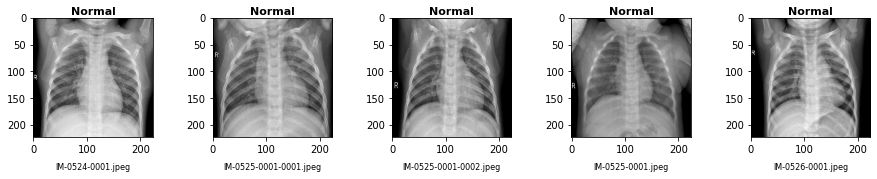

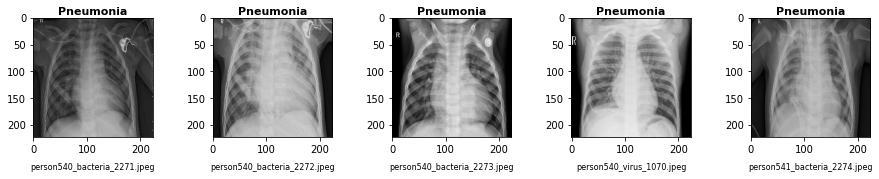

In [0]:
# Creating lists of all image names in the train set directories 
mainDIR_train_NORMAL = os.listdir('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/NORMAL')
mainDIR_train_PNEU = os.listdir('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/PNEUMONIA')

# Printing the number of Normal and Pneumonia images in the train set
print("Number of Normal images in the train set:", len(mainDIR_train_NORMAL))
print("Number of Pneumonia images in the train set:", len(mainDIR_train_PNEU), "\n\n")

# Plotting the first 5 images of the Normal calss 
fig_norm, axes_norm = plt.subplots(1,5, figsize=(15, 15), gridspec_kw=dict(hspace=1.5, wspace=0.5))
for i, ax in enumerate(axes_norm.flat):
    # saving the name of current image: 
    img_file_name_train_NORM = mainDIR_train_NORMAL[i]  
    # loading the image (using keras image class): 
    img_norm = image.load_img("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/NORMAL/"+img_file_name_train_NORM, target_size=(224,224)) 
    # displaying the images:
    ax.imshow(img_norm)
    # adding an header text
    ax.text(0.5,1.05, str("Normal"), color='black',fontsize=11,fontweight=560, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    # adding the current file name at the bottom of each image
    ax.text(0.5,-0.25, str(img_file_name_train_NORM), color='black',fontsize=8,fontweight=500, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

# Plotting the first 5 images of PNEUMONIA class
fig_pneu, axes_pneu = plt.subplots(1,5, figsize=(15, 15), gridspec_kw=dict(hspace=1.5, wspace=0.5))
for i, ax in enumerate(axes_pneu.flat):
    img_file_name_train_PNEU = mainDIR_train_PNEU[i]
    img_pneu = image.load_img("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/PNEUMONIA/"+img_file_name_train_PNEU, target_size=(224,224))
    ax.imshow(img_pneu)
    ax.text(0.5,1.05, str("Pneumonia"), color='black',fontsize=11, fontweight=560, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5,-0.25, str(img_file_name_train_PNEU), color='black',fontsize=8,fontweight=500, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 

# 3. Image Data generation

In [0]:
# Use the Image Data Generator for importing the images from the dataset and for data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range =0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Make sure you provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 4. Define functions for learning diagnostics and image preprocessing before prediction/evaluation 

## 4.1. Define a function for plotting diagnostic learning curves
The fit() method of the model returns a history object, which records the training loss and metrics values, as well as validation loss and validation metrics values.

This function takes the 'history' as an argument and plots two learning curve figures, one for loss and one for accuracy. Blue curves indicate model performance on the training dataset and the orange curves indicate the performance on the test dataset.

In [0]:
def summarize_diagnostics(history):
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0,1.1)
    plt.legend()
    plt.show()
    ## if you want to save the plots to file, uncomment the following lines
    # filename = sys.argv.split('/')[-1]
    # plt.savefig(filename + '_plot.png')
    # plt.close()

## 4.2. Define a function for creating lists of images and their corresponding classes 

Will be used before class prediction and model evaluation

In [0]:
def image_class_gen(class_1_dir_path, class_2_dir_path):

    mainDIR_class_1 = os.listdir(class_1_dir_path)
    mainDIR_class_2 = os.listdir(class_2_dir_path)

    image_list = list()
    class_list = list() 

    # creating lists of validation images and classes
    for img in mainDIR_class_1:
        if 'DS_Store' in img:
            continue
        # loading the image (using keras image class): 
        img_class_1 = image.load_img(str(class_1_dir_path)+img, target_size=(224,224)) 
        # appending images and their classes to lists
        image_list.append(img_class_1)
        class_list.append(0)
  
    for img in mainDIR_class_2:
        if 'DS_Store' in img:
            continue
        # loading the image (using keras image class): 
        img_class_2 = image.load_img(str(class_2_dir_path)+img, target_size=(224,224))
        image_list.append(img_class_2)
        class_list.append(1)

    return image_list, class_list 

## 4.3. Define a function for Image preprocessing bofore prediction and evaluation
The networks used below expect one or more images as an input, and thus the input array need to be 4-dimensional (samples, rows, columns, and channels). For a single sample (one image), the array need to be reshaped to (1, 224, 224, 3).
In addition, pixel values are rescaled to range of 0-1.

In [0]:
def image_preprocess(img_list):
    img_array_list = list()

    for img in img_list:
        image = img_to_array(img)
        img_array_list.append(image)

    img_array_array = np.array(img_array_list)
    #prepro_image_array = preprocess_input(img_array_array)
    prepro_image_array = img_array_array/255

    return prepro_image_array

# 5. Transfer learning - using the VGG-16 CNN model

The Oxford Visual Geometry Group (VGG) participated and won the ILSVRC challenge for development of state-of-the-art CNN image classifier.

The work was published in 2014 in a paper: Very Deep Convolutional Networks for Large-Scale Image Recognition, making the models and learned weights available online.

VGG released two different CNN models, specifically a 16-layer model (VGG-16) and a 19-layer model (VGG-19).

These models can be loaded and used in the Keras library, via
Keras Applications interface for loading and using pre-trained models.


## 5.1. Defining the target size of the images 

In [0]:
image_size = [224,224]

## 5.2. Import the VGG-16 model and setting up the weights

In [0]:
# define a classification model:
# Import the Vgg 16 library, using imagenet weights, 
#and setting the include_top to False to drop the first and last layer (since we have only two classes and not a thousand, and we provide the image size ) 

vgg16 = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 6s 0us/step


## 5.3. Prevent training existing weights

In [0]:
for layer in vgg16.layers:
    layer.trainable = False

## 5.4. Getting the number of output classes

In [0]:
folders = glob('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/*')
print(folders)

['/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/PNEUMONIA', '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/NORMAL']


## 5.5. Define the last layer, create the model and view its structure

In [0]:
# After dropping the last layer, we define our flattened layer (more layers can be added if required)
x = Flatten()(vgg16.output)

In [0]:
# define the last layer of the model with number of nodes equal to the number of classess
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
vgg16_model = Model(inputs=vgg16.input, outputs=prediction)

In [0]:
# view the structure of the model 
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 5.6. Define the cost and optimization methods to be used by the model 

In [0]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 5.7. Fit the model

In [0]:
history = vgg16_model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))


Epoch 1/50
163/163 [==============================] - 3044s 19s/step - loss: 0.2024 - accuracy: 0.9235 - val_loss: 0.3592 - val_accuracy: 0.9199
Epoch 2/50
163/163 [==============================] - 135s 827ms/step - loss: 0.1105 - accuracy: 0.9601 - val_loss: 0.0380 - val_accuracy: 0.9135
Epoch 3/50
163/163 [==============================] - 142s 868ms/step - loss: 0.0938 - accuracy: 0.9676 - val_loss: 0.4070 - val_accuracy: 0.9135
Epoch 4/50
163/163 [==============================] - 143s 876ms/step - loss: 0.0870 - accuracy: 0.9655 - val_loss: 1.1276 - val_accuracy: 0.8478
Epoch 5/50
163/163 [==============================] - 143s 876ms/step - loss: 0.1000 - accuracy: 0.9628 - val_loss: 0.0080 - val_accuracy: 0.8958
Epoch 6/50
163/163 [==============================] - 143s 875ms/step - loss: 0.0837 - accuracy: 0.9691 - val_loss: 0.0736 - val_accuracy: 0.8558
Epoch 7/50
163/163 [==============================] - 151s 926ms/step - loss: 0.0720 - accuracy: 0.9709 - val_loss: 1.2126 -

# 5.8. Saving the trained model

In [0]:
# Required to save models in HDF5 format
!pip install pyyaml h5py  

In [0]:
# save model
vgg16_model.save('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg16_Model_x_ray_50epochs.h5')

## 5.9. Visualize the learning curve (accuracy and loss of the train and test sets)

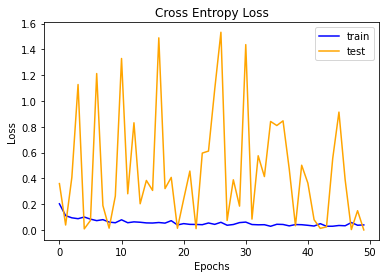

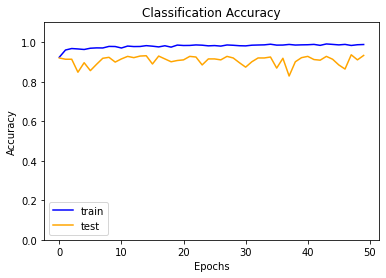

In [0]:
summarize_diagnostics(history)

## 5.10. Printing a summary of model performance

In [0]:
loss_list_vgg16 = history.history['loss']
val_loss_list_vgg16 = history.history['val_loss']
acc_list_vgg16 = history.history['accuracy']
val_acc_list_vgg16 = history.history['val_accuracy']

print("Epochs =", np.array(val_loss_list_vgg16).argmin()+1,"gave the lowest loss value of %.2f" %np.array(val_loss_list_vgg16).min())
print("Epochs =", np.array(val_acc_list_vgg16).argmax()+1,"gave the highest accuracy with value of", str(np.array(val_acc_list_vgg16).max()*100)+'%')

print("\nThe accuracy of the model (with 50 epoch) is: "+ str(val_acc_list_vgg16[-1]*100)+'%')
print("The loss of the model (with 50 epoch) is: "+ str(val_loss_list_vgg16[-1]))
print("\nThe averaged accuracy of all epochs is :"+str(np.mean(val_acc_list_vgg16)*100)+'%')

Epochs = 50 gave the lowest loss value of 0.00
Epochs = 48 gave the highest accuracy with value of 93.58974099159241%

The accuracy of the model (with 50 epoch) is: 93.2692289352417%
The loss of the model (with 50 epoch) is: 1.1808082490460947e-05

The averaged accuracy of all epochs is :90.73076891899109%


## 5.11. Summary

**The model yields good prediction accuracy of over 93%.**

The model started learning the data with equivalent accuracy level, starting from the first epoch, demonstrating slight fluctuations, which represent the variability of the model training process due to the stochastic nature of the optimization algorithm.




## 5.12. Recreate the model from the saved file and print model architecture

In [0]:
# Recreate the pretrained VGG-16 model, including its weights and the optimizer
VGG16_Final_Model = tf.keras.models.load_model('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg16_Model_x_ray_50epochs.h5')

# Loading the model can also be performed by:
#from keras.models import load_model
#VGG16_Final_Model = load_model('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg16_Model_x_ray_50epochs.h5')

# Show the model architecture
VGG16_Final_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 5.13. Creating lists of images and their corresponding classes (for class prediction and model evaluation)




### 5.13.1. Running the image_class_gen() function 

In [0]:
mainDIR_test_NORMAL = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test/NORMAL/'
mainDIR_test_PNEU = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test/PNEUMONIA/'

test_img_list, test_class_list = image_class_gen(mainDIR_test_NORMAL, mainDIR_test_PNEU)

### 5.13.2. Checking the function's output

Image list:  [<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A0BD8A438>, <PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A0BD8A8D0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A09765400>, <PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A097651D0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A09765940>]
Class list:  [0, 0, 0, 0, 0]

Length of image list:  624
Length of class list:  624

Names of first images:
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg

Class of presented image: 0


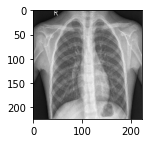


Class of presented image: 1


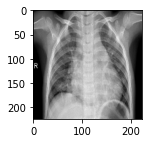

In [0]:
print("Image list: ", test_img_list[:5])
print("Class list: ",test_class_list[:5])
print()
print("Length of image list: ", len(test_img_list))
print("Length of class list: ", len(test_class_list))
print() 

print("Names of first images:")
for img_name in os.listdir(mainDIR_test_NORMAL)[:5]:
    print(img_name)

print("\nClass of presented image:", test_class_list[0])
plt.figure(figsize=(2,2))
plt.imshow(test_img_list[0])
plt.show()

print("\nClass of presented image:", test_class_list[-1])
plt.figure(figsize=(2,2))
plt.imshow(test_img_list[-1])
plt.show()

## 5.14. Image preprocessing for prediction and evaluation

Running the image_preprocess() function




In [0]:
prepro_test_image_array = image_preprocess(test_img_list)
print("The shape of the preprocessed image array: ", prepro_test_image_array.shape)

The shape of the preprocessed image array:  (624, 224, 224, 3)


## 5.15. Predicting the class of the test set images
The predict method returns the probability of an image to be of each given class. The argmax() function is used to select the higher probability.  


In [0]:
yhat = VGG16_Final_Model.predict(prepro_test_image_array)
predY_label = np.argmax(yhat, axis=1)

## 5.16. Evaluating model performance 

### 5.16.1. Accuracy score (using Scikit-learn and Keras functions)

In [0]:
accuracy_score(test_class_list, predY_label)

0.9326923076923077

In [0]:
VGG16_Final_Model.evaluate(x= prepro_test_image_array, y=to_categorical(test_class_list))

624/624 [==============================] - 4s 6ms/sample - loss: 0.5277 - acc: 0.9327


[0.5277298584264011, 0.9326923]

### 5.16.2. Calculating and displaying the confusion matrix

Text(83.40000000000006, 0.5, 'True values')

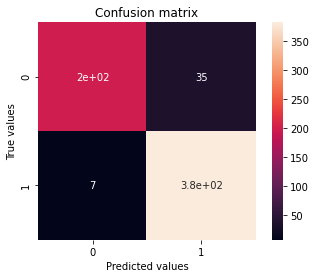

In [0]:
con_mat = confusion_matrix(test_class_list, predY_label)
plt.subplots(figsize=(6,4))
sns.heatmap(con_mat, square=True, annot=True, cbar=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted values')
plt.ylabel('True values')

### 5.16.3. Exploring the classification report 

In [0]:
print(metrics.classification_report(predY_label,test_class_list))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       206
           1       0.98      0.92      0.95       418

    accuracy                           0.93       624
   macro avg       0.92      0.94      0.93       624
weighted avg       0.94      0.93      0.93       624



### **The VGG-16 model yields good prediction accuracy of above 93%, with precision of 0.94 and recall of 0.93**

#   


# 6. **Transfer learning - using the VGG-19 CNN model**

## 6.1. Import the VGG-19 model and setting up the weights

In [0]:
# Import the Vgg 19 library, using imagenet weights, and setting the include_top to False to drop the first and last layer 
#(since we have only two classes and not thousands, and we provide the image size ) 

vgg19 = VGG19(input_shape=image_size + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 7s 0us/step


## 6.2. Prevent training existing weights

In [0]:
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False
    #print(layer)
       
#print(len(vgg19.layers))

## 6.3. Getting the number of output classes


In [0]:
folders = glob('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/*')
print(folders)

['/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/PNEUMONIA', '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/NORMAL']


## 6.4. Define the last layer, create the model and view its structure


In [0]:
# After dropping the last layer, we define our layer, a flattened layer (more layers can be added if required)
x = Flatten()(vgg19.output)

In [0]:
# define the last layer of the model with number of nodes equal to the number of classess
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
vgg19_model = Model(inputs=vgg19.input, outputs=prediction)

In [0]:
# view the structure of the model 
vgg19_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 6.5. Define the cost and optimization methods to be used by the model 

In [0]:
# Define the cost and optimization methods to be used by the model 
vgg19_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 6.6. Fit the model

In [0]:
# fit the model
history_vgg19 = vgg19_model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
163/163 [==============================] - 150s 920ms/step - loss: 0.2494 - accuracy: 0.9120 - val_loss: 0.3720 - val_accuracy: 0.8814
Epoch 2/50
163/163 [==============================] - 144s 885ms/step - loss: 0.1256 - accuracy: 0.9528 - val_loss: 0.1283 - val_accuracy: 0.9119
Epoch 3/50
163/163 [==============================] - 147s 902ms/step - loss: 0.1276 - accuracy: 0.9521 - val_loss: 0.1418 - val_accuracy: 0.9199
Epoch 4/50
163/163 [==============================] - 146s 897ms/step - loss: 0.1235 - accuracy: 0.9603 - val_loss: 0.5356 - val_accuracy: 0.9135
Epoch 5/50
163/163 [==============================] - 146s 894ms/step - loss: 0.1033 - accuracy: 0.9609 - val_loss: 0.0857 - val_accuracy: 0.9006
Epoch 6/50
163/163 [==============================] - 146s 896ms/step - loss: 0.1027 - accuracy: 0.9647 - val_loss: 0.3813 - val_accuracy: 0.8446
Epoch 7/50
163/163 [==============================] - 147s 903ms/step - loss: 0.1155 - accuracy: 0.9594 - val_loss: 0.4002 -

## 6.7. Saving the trained model

In [0]:
# Required to save models in HDF5 format
!pip install pyyaml h5py  

In [0]:
# save model
vgg19_model.save('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg19_Model_x_ray_50epochs.h5')

## 6.8. Visualize the learning curve (accuracy and loss of the train and test sets)


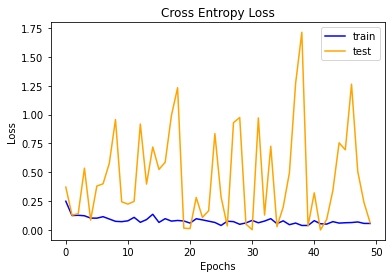

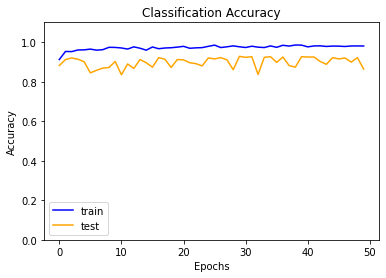

In [0]:
summarize_diagnostics(history_vgg19)

## 6.9. Printing a summary of model performance

In [0]:
loss_list_vgg19 = history_vgg19.history['loss']
val_loss_list_vgg19 = history_vgg19.history['val_loss']
acc_list_vgg19 = history_vgg19.history['accuracy']
val_acc_list_vgg19 = history_vgg19.history['val_accuracy']

print("Epochs =", np.array(val_loss_list_vgg19).argmin()+1,"gave the lowest loss value of %.2f" %np.array(val_loss_list_vgg19).min())
print("Epochs =", np.array(val_acc_list_vgg19).argmax()+1,"gave the highest accuracy with value of", str(np.array(val_acc_list_vgg19).max()*100)+'%')

print("\nThe accuracy of the model (with 50 epoch) is: "+ str(val_acc_list_vgg19[-1]*100)+'%')
print("The loss of the model (with 50 epoch) is: "+ str(val_loss_list_vgg19[-1]))
print("\nThe averaged accuracy of all epochs is :"+str(np.mean(val_acc_list_vgg19)*100)+'%')

Epochs = 42 gave the lowest loss value of 0.00
Epochs = 30 gave the highest accuracy with value of 92.78846383094788%

The accuracy of the model (with 50 epoch) is: 86.37820482254028%
The loss of the model (with 50 epoch) is: 0.06183693930506706

The averaged accuracy of all epochs is :89.82692277431488%


## 6.10. Summary

**The model yields prediction accuracy of over 86%.**

The model started learning the data with equivalent accuracy level, starting from the first epoch, demonstrating slight fluctuations, which represent the variability of the model training process due to the stochastic nature of the optimization algorithm.

## 6.11. Recreate the model from the saved file and print model architecture

In [0]:
# Recreate the exact same model, including its weights and the optimizer
VGG19_Final_Model = tf.keras.models.load_model('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg19_Model_x_ray_50epochs.h5')

# Show the model architecture
VGG19_Final_Model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 6.12. Creating lists of images and their corresponding classes (for class prediction and model evaluation)

In [0]:
mainDIR_test_NORMAL = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test/NORMAL/'
mainDIR_test_PNEU = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test/PNEUMONIA/'

# Creating list of images and their classes using the image_class_gen() function
test_img_list, test_class_list = image_class_gen(mainDIR_test_NORMAL, mainDIR_test_PNEU)

# Image preprocessing 
prepro_test_image_array = image_preprocess(test_img_list)

## 6.13. Predicting the class of the test set images

In [0]:
yhat = VGG19_Final_Model.predict(prepro_test_image_array)
predY_label = np.argmax(yhat, axis=1)

## 6.14. Evaluating model performance 

VGG19 model accuracy: 0.8637820512820513 


VGG19 model classificatoin report:
               precision    recall  f1-score   support

           0       0.64      0.99      0.78       151
           1       1.00      0.82      0.90       473

    accuracy                           0.86       624
   macro avg       0.82      0.91      0.84       624
weighted avg       0.91      0.86      0.87       624
 




Text(83.40000000000006, 0.5, 'True values')

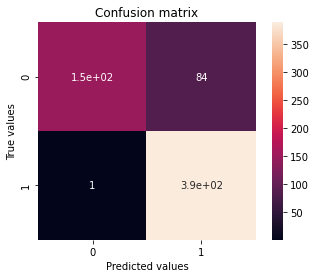

In [0]:
# Prining VGG19 accuracy score
print('VGG19 model accuracy:', accuracy_score(test_class_list, predY_label), '\n\n')

# Printing the classificatoin report
print("VGG19 model classificatoin report:\n",metrics.classification_report(predY_label,test_class_list), "\n\n")

# Displaying the confusion matrix
con_mat = confusion_matrix(test_class_list, predY_label)
plt.subplots(figsize=(6,4))
sns.heatmap(con_mat, square=True, annot=True, cbar=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted values')
plt.ylabel('True values')

### **The VGG-19 model yields prediction accuracy of above 86% (lower from the VGG-16 model) with precision of 0.91 and recall of 0.86**

#   

# 7. **Prediction of bacterial vs. viral infections among the diagnosed  pneumonia patients**

Treatment of bacterial pneumonia differ significantly from a viral pneumonia. Thus, in the following part of the project images of pneumonia patients were divided into two additional categories ("Bacteria"/"Virus") to predict the type of infection causing the disease. While bacterial infections can be treated using antibiotics, viral infection cannot. Therefore, predicting the source of infection can assist determine the appropriate route of treatment in these medical conditions.   

 ### This task will be addressed via transfer learning using the VGG-16 model

## 7.1. Setting up the data sets

### 7.1.1.  Creating the required folder
Folders of train and test sets are created, each divided into "bacteria" and "virus" classes 

In [0]:
os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only")

In [0]:
os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train")
os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/bacteria")
os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/virus")

os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test")
os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test/bacteria")
os.mkdir("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test/virus")

### 7.1.2 Copying files from the original PNEUMONIA dataset to new folders of "Bacteria" and "Virus" classes

This is performed using the labels of each image (bacteria or virus)

In [0]:
# Copying files of the test set
src_test_pneu = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/test/PNEUMONIA' 
src_files = os.listdir(src_test_pneu)
dest_test_bacteria = "/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test/bacteria" 
dest_test_virus = "/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test/virus" 

for file_name in src_files:
    full_file_name = os.path.join(src_test_pneu, file_name)
    if os.path.isfile(full_file_name):
        if 'bacteria' in file_name:
            shutil.copy(full_file_name, dest_test_bacteria)

        elif 'virus' in file_name:
            shutil.copy(full_file_name, dest_test_virus)
            
        else: 
            print("This file is not under bacteria or virus category: ", full_file_name)

    else: 
        continue

In [0]:
# Copying files of the train set
src_test_pneu = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray/train/PNEUMONIA' 
src_files = os.listdir(src_test_pneu)
dest_test_bacteria = "/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/bacteria" 
dest_test_virus = "/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/virus" 

for file_name in src_files:
    full_file_name = os.path.join(src_test_pneu, file_name)
    if os.path.isfile(full_file_name):
        if 'bacteria' in file_name:
            shutil.copy(full_file_name, dest_test_bacteria)
            
        elif 'virus' in file_name:
            shutil.copy(full_file_name, dest_test_virus)
            
        else: 
            print("This file is not under bacteria or virus category: ", full_file_name)

    else: 
        continue

# 7.2. Visualizing images from the Bacteria and Virus classes  
Images are displayed from the train data set

Number of Bacteria calss images in the train set: 2530
Number of Virus calss images in the train set: 1345 




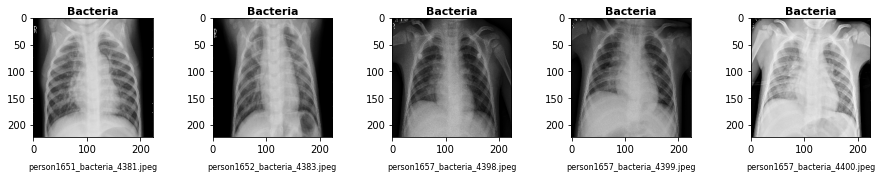

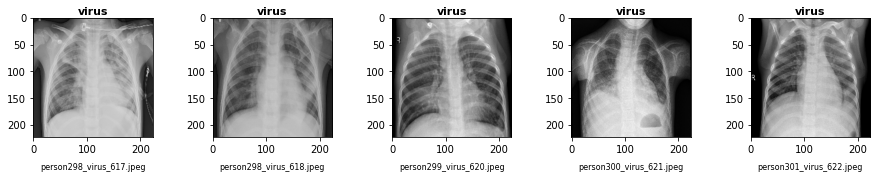

In [0]:
# Creating lists of all image names in the train set directories 
mainDIR_train_bacteria = os.listdir('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/bacteria')
mainDIR_train_virus = os.listdir('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/virus')


# Printing the number of images in the Bacteria and Virus train sets
print("Number of Bacteria calss images in the train set:", len(mainDIR_train_bacteria))
print("Number of Virus calss images in the train set:", len(mainDIR_train_virus), "\n\n")


# Plotting the first 5 images of the Bacteria calss 
fig_bact, axes_bact = plt.subplots(1,5, figsize=(15, 15), gridspec_kw=dict(hspace=1.5, wspace=0.5))
for i, ax in enumerate(axes_bact.flat):
    # saving the name of current image: 
    img_file_name_train_bact = mainDIR_train_bacteria[i]  
    # loading the image (using keras image class): 
    img_bact = image.load_img("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/bacteria/"+img_file_name_train_bact, target_size=(224,224)) 
    # displaying the images:
    ax.imshow(img_bact)
    # adding an header text
    ax.text(0.5,1.05, str("Bacteria"), color='black',fontsize=11,fontweight=560, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    # adding the current file name at the bottom of each image
    ax.text(0.5,-0.25, str(img_file_name_train_bact), color='black',fontsize=8,fontweight=500, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

# Plotting the first 5 images of Virus class
fig_virus, axes_virus = plt.subplots(1,5, figsize=(15, 15), gridspec_kw=dict(hspace=1.5, wspace=0.5))
for i, ax in enumerate(axes_virus.flat):
    # saving the name of current image: 
    img_file_name_train_virus = mainDIR_train_virus[i]
    # loading the image (using keras image class):   
    img_virus = image.load_img("/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/virus/"+img_file_name_train_virus, target_size=(224,224))
    # displaying the images:
    ax.imshow(img_virus)
    # adding an header text
    ax.text(0.5,1.05, str("virus"), color='black',fontsize=11, fontweight=560, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    # adding the current file name at the bottom of each image
    ax.text(0.5,-0.25, str(img_file_name_train_virus), color='black',fontsize=8,fontweight=500, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes) 

# 7.3. Image Data generation

In [0]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range =0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)


# Make sure you provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 3875 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


## 7.4. Importing and setting up the VGG-16 model

In [0]:
#Definig the target size of the images
image_size = [224,224]

vgg16 = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

# Prvent training existing weights
for layer in vgg16.layers:
    layer.trainable = False

# Getting the number of output classes
folders = glob('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/train/*')

# define the last layer, as flattened layer
x = Flatten()(vgg16.output)

# Define the last layer of the model with number of nodes equal to the number of classess
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
vgg16_model = Model(inputs=vgg16.input, outputs=prediction)

# view the structure of the model 
vgg16_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112

## 7.5. Compile and fit the model 

In [0]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_VGG16_pneu_diagnosed = vgg16_model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))


Epoch 1/50
103/122 [========================>.....] - ETA: 6:43 - loss: 0.6331 - accuracy: 0.7089

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 75 could not be retrieved. It could be because a worker has died.
  UserWarning)


122/122 [==============================] - 2642s 22s/step - loss: 0.6213 - accuracy: 0.7159 - val_loss: 0.4760 - val_accuracy: 0.8974
Epoch 2/50
122/122 [==============================] - 67s 548ms/step - loss: 0.6091 - accuracy: 0.7249 - val_loss: 0.6307 - val_accuracy: 0.7897
Epoch 3/50
122/122 [==============================] - 73s 598ms/step - loss: 0.5749 - accuracy: 0.7355 - val_loss: 0.1269 - val_accuracy: 0.8564
Epoch 4/50
122/122 [==============================] - 72s 592ms/step - loss: 0.5663 - accuracy: 0.7443 - val_loss: 0.4101 - val_accuracy: 0.8436
Epoch 5/50
122/122 [==============================] - 72s 588ms/step - loss: 0.5195 - accuracy: 0.7672 - val_loss: 0.4302 - val_accuracy: 0.8564
Epoch 6/50
122/122 [==============================] - 71s 581ms/step - loss: 0.5138 - accuracy: 0.7628 - val_loss: 1.1593 - val_accuracy: 0.8641
Epoch 7/50
122/122 [==============================] - 71s 584ms/step - loss: 0.4933 - accuracy: 0.7721 - val_loss: 0.2655 - val_accuracy: 0.9

## 7.6. Saving the trained model

In [0]:
# Required to save models in HDF5 format
!pip install pyyaml h5py  

In [0]:
# save model
vgg16_model.save('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg16_Model_pneu_diagnosed_xray_50epochs.h5')

## 7.7. Visualize the learning curve (accuracy and loss of the train and test sets)

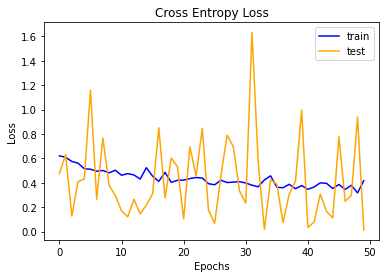

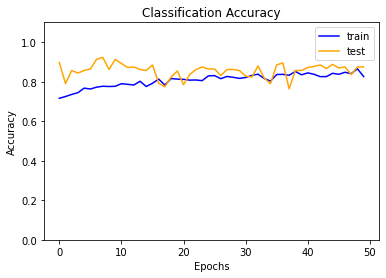

In [0]:
summarize_diagnostics(history_VGG16_pneu_diagnosed)

## 7.8. Printing a summary of model performance

In [0]:
loss_list_vgg16 = history_VGG16_pneu_diagnosed.history['loss']
val_loss_list_vgg16 = history_VGG16_pneu_diagnosed.history['val_loss']
acc_list_vgg16 = history_VGG16_pneu_diagnosed.history['accuracy']
val_acc_list_vgg16 = history_VGG16_pneu_diagnosed.history['val_accuracy']

print("Epochs =", np.array(val_loss_list_vgg16).argmin()+1,"gave the lowest loss value of %.2f" %np.array(val_loss_list_vgg16).min())
print("Epochs =", np.array(val_acc_list_vgg16).argmax()+1,"gave the highest accuracy with value of", str(np.array(val_acc_list_vgg16).max()*100)+'%')

print("\nThe accuracy of the model (with 50 epoch) is: "+ str(val_acc_list_vgg16[-1]*100)+'%')
print("The loss of the model (with 50 epoch) is: "+ str(val_loss_list_vgg16[-1]))
print("\nThe averaged accuracy of all epochs is: "+str(np.mean(val_acc_list_vgg16)*100)+'%')

Epochs = 50 gave the lowest loss value of 0.01
Epochs = 8 gave the highest accuracy with value of 92.30769276618958%

The accuracy of the model (with 50 epoch) is: 87.43589520454407%
The loss of the model (with 50 epoch) is: 0.013677761889994144

The averaged accuracy of all epochs is: 85.61538422107697%


## 7.9. Summary

**Considering the low number of training images, the model yields good prediction accuracy of over 87%.**

The model started learning the data with equivalent accuracy level, starting from the first epoch, demonstrating slight fluctuations, which represent the variability of the model training process due to the stochastic nature of the optimization algorithm.




## 7.10. Recreate the model from the saved file and print model architecture

In [0]:
# Recreate the pretrained VGG-16 model, including its weights and the optimizer
VGG16_Pneu_Diagnosed_Final_Model = tf.keras.models.load_model('/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/vgg16_Model_pneu_diagnosed_xray_50epochs.h5')

# Show the model architecture
VGG16_Pneu_Diagnosed_Final_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 7.11. Creating lists of images and their corresponding classes (for class prediction and model evaluation)

In [0]:
mainDIR_test_bacteria = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test/bacteria/'
mainDIR_test_virus = '/content/drive/My Drive/Chest_XRay_Images_Pneumonia_Classification/chest_xray_PNEU_diagnosed_only/test/virus/'

# Creating list of images and their classes using the image_class_gen() function
test_img_list, test_class_list = image_class_gen(mainDIR_test_bacteria, mainDIR_test_virus)

# Image preprocessing 
prepro_test_image_array = image_preprocess(test_img_list)

## 7.12. Predicting the class of the test set images

In [0]:
yhat = VGG16_Pneu_Diagnosed_Final_Model.predict(prepro_test_image_array)
predY_label = np.argmax(yhat, axis=1)

## 7.13. Evaluating model performance 

VGG16 model accuracy: 87.43589743589743% 


VGG16 model classificatoin report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.91       283
           1       0.70      0.96      0.81       107

    accuracy                           0.87       390
   macro avg       0.84      0.90      0.86       390
weighted avg       0.90      0.87      0.88       390
 




Text(83.40000000000006, 0.5, 'True values')

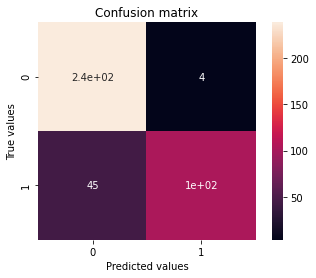

In [0]:
# Prining VGG16 accuracy score
print('VGG16 model accuracy: '+str(accuracy_score(test_class_list, predY_label)*100)+'%', '\n\n')

# Printing the classificatoin report
print("VGG16 model classificatoin report:\n",metrics.classification_report(predY_label,test_class_list), "\n\n")

# Displaying the confusion matrix
con_mat = confusion_matrix(test_class_list, predY_label)
plt.subplots(figsize=(6,4))
sns.heatmap(con_mat, square=True, annot=True, cbar=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted values')
plt.ylabel('True values')

### **The VGG-16 model yields prediction accuracy of above 87% with precision of 0.90 and recall of 0.87**